# Libraries

In [63]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from pathlib import Path
import sys

root = str(Path().resolve().parent)
if root not in sys.path:
    sys.path.append(root)
print(*sys.path, sep="\n")

# %matplotlib ipympl
%matplotlib inline

/usr/lib/python312.zip
/usr/lib/python3.12
/usr/lib/python3.12/lib-dynload

/home/ryanwtsai/repos/rfdsp_sim/python/venv/lib/python3.12/site-packages
/home/ryanwtsai/repos/rfdsp_sim/python


In [64]:
from importlib import reload
from rfdsppy import calc, ofdm, rf_analog, rf_tx_fw, tonegen

reload(calc)
reload(ofdm)
reload(rf_analog)
reload(rf_tx_fw)
reload(tonegen)

<module 'rfdsppy.tonegen' from '/home/ryanwtsai/repos/rfdsp_sim/python/rfdsppy/tonegen.py'>

# Phase Noise

EVM: 0.69%
SNR: 43.25101046033544
-42.91044295366065


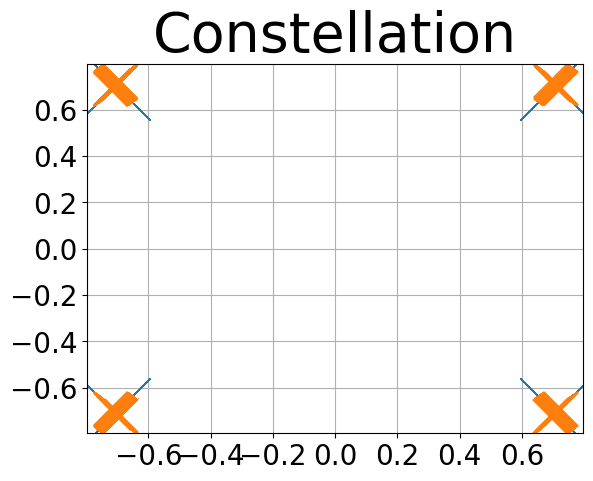

In [65]:
modorder = 4
bw = 20
scs = 15
num_sc = 1200
start_sc = 600-round(num_sc/2)
en_tprecode = True
osr = 4
wola = 0
ofdm_wavgen = ofdm.OFDMWavGen(bw, scs, modorder, start_sc, num_sc=num_sc, en_tprecode=en_tprecode, osr=osr, wola=wola)

x, x_standard = ofdm_wavgen.generate(14)
cfg = ofdm_wavgen.get_demod_params()

# x = tonegen.tonegen(cfg.get("fs"), fc=10, cossin="exp", power=0)
pn = rf_analog.PhaseNoise(-95, -150, 100/1000, 1/1000, cfg.get("fs"))
# pn = rf_analog.PhaseNoise(-10, -70, 10, 0.001, cfg.get("fs"))
y = pn.transform(x)

evm = ofdm_wavgen.calculate_evm(x_standard, y[round(cfg["wola_len"]/2):], en_plot=True)
print(f"EVM: {evm.round(2)}%")
print(f"SNR: {-20*np.log10(evm/100)}")
print(20*np.log10(calc.rms(pn.theta_)))

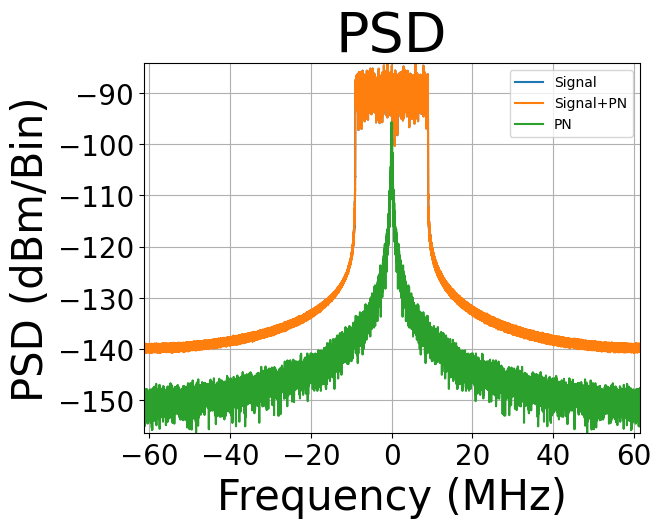

In [68]:
fs = cfg.get("fs")
rbw = scs/1000/2**2

py, f = calc.psd(y, fs, rbw)
px, _ = calc.psd(x, fs, rbw)
pz, _ = calc.psd(pn.theta_, fs, rbw)
# py = calc.scale_psd(py, f, bw, scs, start_sc, num_sc)
# px = calc.scale_psd(px, f, bw, scs, start_sc, num_sc)

fig = plt.figure()
plt.plot(f, 10*np.log10(px), label="Signal")
plt.plot(f, 10*np.log10(py), label="Signal+PN")
plt.plot(f, 10*np.log10(pz), label="PN")
plt.title("PSD", {'fontsize':40})
plt.xlabel("Frequency (MHz)", {'fontsize':30})
plt.ylabel("PSD (dBm/Bin)", {'fontsize':30})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.autoscale(enable=True, axis='both', tight=True)
plt.legend(loc="best")
plt.grid()

In [66]:
print(f"IPN: {10*np.log10(pn.P_.sum()*(pn.Pf_[1]-pn.Pf_[0])*1e6).round(3)}")
10*np.log10(calc.rms(pn.theta_)**2)

IPN: -42.910000000000004


np.float64(-42.91044295366065)

/tmp/ipykernel_1805/2019873878.py:3: RuntimeWarning: divide by zero encountered in log10
  axs[1].semilogx(pn.Ff_, 20*np.log10(np.abs(pn.F_)))


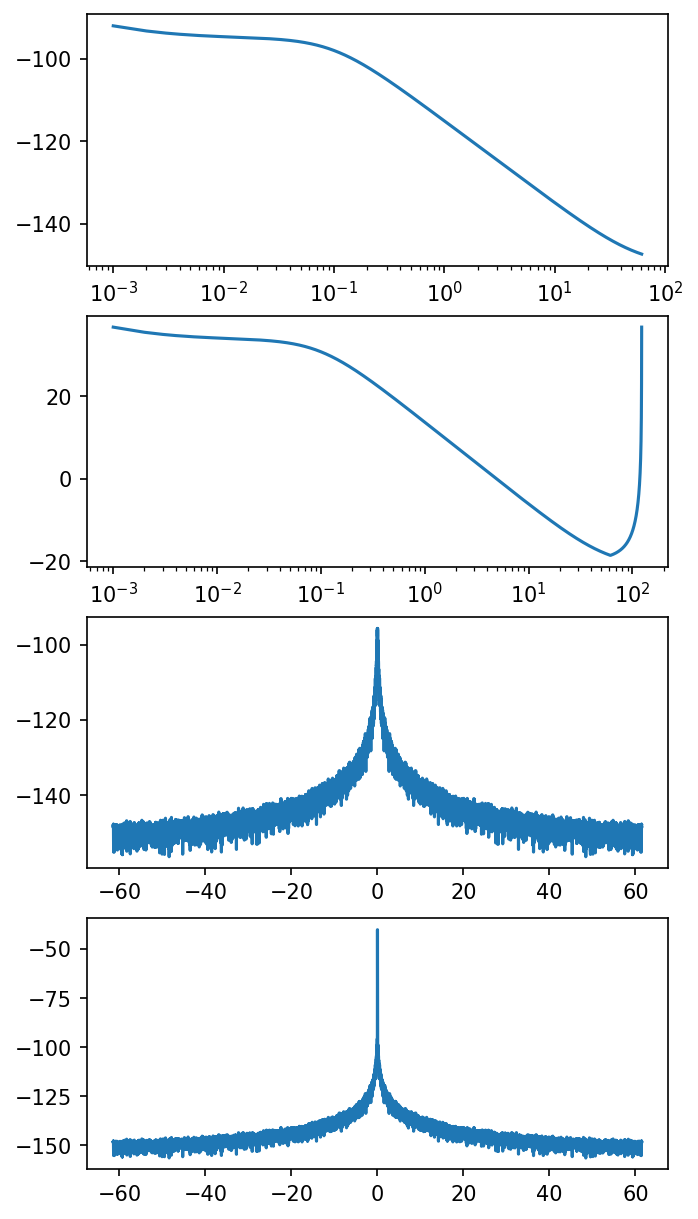

In [67]:
fig, axs = plt.subplots(nrows=4, dpi=150, figsize=(5, 10))
axs[0].semilogx(pn.Pf_, 10*np.log10(pn.P_))
axs[1].semilogx(pn.Ff_, 20*np.log10(np.abs(pn.F_)))
# axs[2].plot(pn.Ff_[::2**12], np.angle(pn.F_[::2**12]))

fs = cfg.get("fs")
rbw = scs/1000/2**2
ptheta, f = calc.psd(pn.theta_, fs, rbw)
axs[2].plot(f, 10*np.log10(ptheta))

ptheta2, f = calc.psd(np.exp(1j*pn.theta_), fs, rbw)
axs[3].plot(f, 10*np.log10(ptheta2))